In [13]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

from skimage.morphology import erosion, dilation,binary_erosion, opening, disk
import cv2

from skimage.filters.rank import entropy

from tp2 import my_segmentation, evaluate

from skimage.morphology import thin

Accuracy = 0.14429232549170845, Recall = 0.8434400360685302


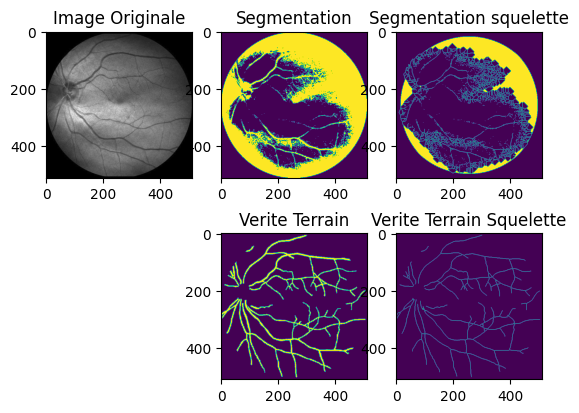

In [15]:
img =  np.asarray(Image.open('./images_IOSTAR/star01_OSC.jpg')).astype(np.uint8)

nrows, ncols = img.shape
row, col = np.ogrid[:nrows, :ncols]

img_mask = (np.ones(img.shape)).astype(np.bool_)
invalid_pixels = ((row - nrows / 2) ** 2 + (col - ncols / 2) ** 2 > (nrows / 2) ** 2)
img_mask[invalid_pixels] = 0

img_out = my_segmentation(img, img_mask, 85)

img_GT =  np.asarray(Image.open('./images_IOSTAR/GT_01.png')).astype(np.bool_)

evaluate(img_out, img_GT)

img_out_skel = thin(img_out, max_num_iter = 15)
GT_skel = thin(img_GT, max_num_iter = 15)

plt.subplot(231)
plt.imshow(img,cmap = 'gray')
plt.title('Image Originale')
##################################
plt.subplot(232)
plt.imshow(img_out)
plt.title('Segmentation')
##################################
plt.subplot(233)
plt.imshow(img_out_skel)
plt.title('Segmentation squelette')
##################################
plt.subplot(235)
plt.imshow(img_GT)
plt.title('Verite Terrain')
##################################
plt.subplot(236)
plt.imshow(GT_skel)
plt.title('Verite Terrain Squelette')
plt.show()

Accuracy = 0.10056818181818182, Recall = 0.06584821428571429


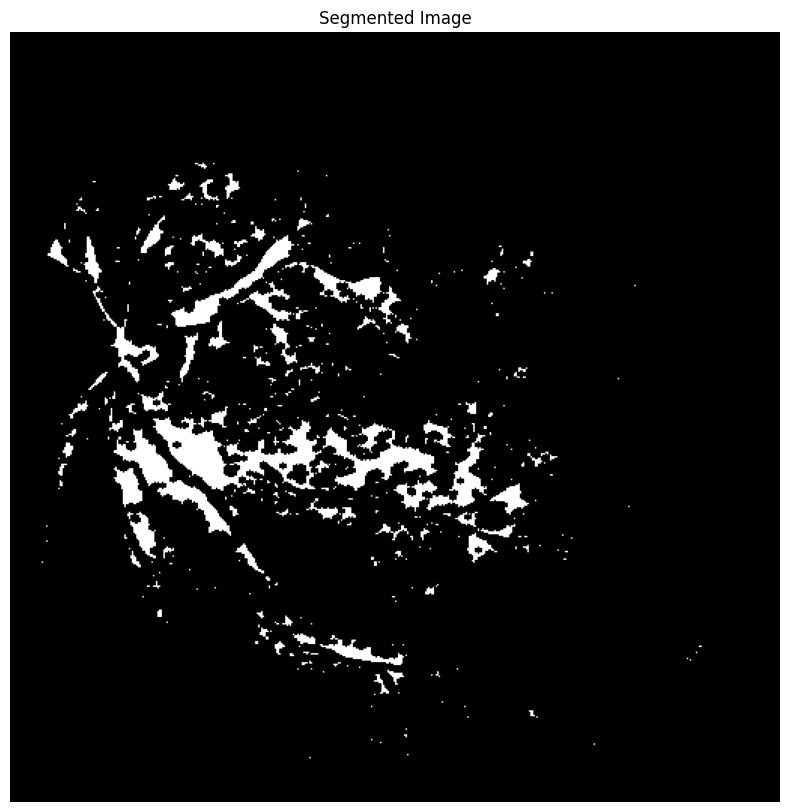

In [17]:
# Charger l'image
image = cv2.imread('./images_IOSTAR/star01_OSC.jpg', 0)  
# image en niveaux de gris

# Prétraitement de l'image
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
preprocessed_image = clahe.apply(image)

# Filtrage pour détecter les vaisseaux sanguins
vessel_image = cv2.morphologyEx(preprocessed_image, cv2.MORPH_TOPHAT, cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15)))

# Binarisation
ret, binary_image = cv2.threshold(vessel_image, 60, 255, cv2.THRESH_BINARY)

# Post-traitement
binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

evaluate(binary_image, img_GT)

# Afficher l'image segmentée
plt.figure(figsize=(10, 10))
plt.imshow(binary_image, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')
plt.show()


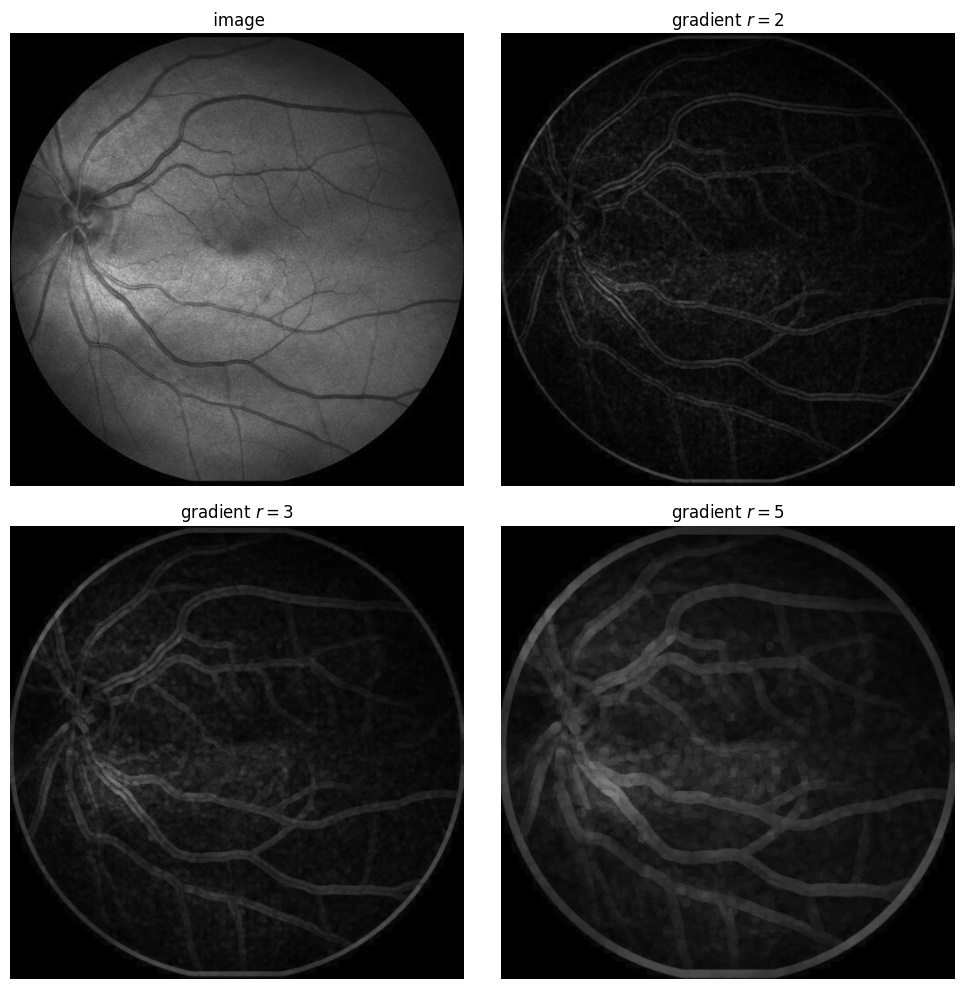

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, vmin=0, vmax=255, cmap=plt.cm.gray)
ax[0].set_title(' image')

ax[1].imshow(dilation(image, disk(2)) -erosion(image, disk(2)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[1].set_title('gradient $r=2$')

ax[2].imshow(dilation(image, disk(3))-erosion(image, disk(3)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[2].set_title('gradient $r=3$')

ax[3].imshow(dilation(image, disk(5))-erosion(image, disk(5)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[3].set_title('gradient $r=5$')

for a in ax:
    a.axis('off')

plt.tight_layout()

In [19]:
# original_image =  np.asarray(Image.open('./images_IOSTAR/star01_OSC.jpg')).astype(np.uint8)
original_image =  np.array(Image.open('./images_IOSTAR/star01_OSC.jpg'))
image_entropy = entropy(original_image, disk(15)).astype(np.uint8)

In [20]:
evaluate(image_entropy, img_GT)
# print('Accuracy =', ACCU,', Recall =', RECALL)

Accuracy = 0.12777481310065883, Recall = 0.9201925149055384


Accuracy = 0.11027702691069369, Recall = 0.9078989333427833


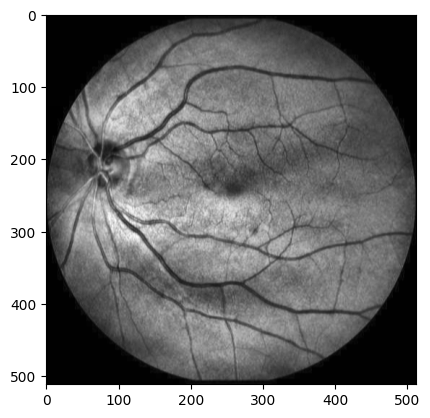

In [22]:
def matched_filter(image, kernel):
    # Convolve the image with the matched filter kernel
    return cv2.filter2D(image, -1, kernel)

gabor_kernel = cv2.getGaborKernel((15, 15), 7, np.pi/3, 6, 0.3)

gaussian_kernel = cv2.getGaussianKernel(30, np.pi/3)

image_with_kernel = matched_filter(preprocessed_image, gaussian_kernel)

evaluate(image_with_kernel, img_GT)

plt.imshow(image_with_kernel, cmap = 'gray')

In [23]:
def local_entropy_threshold(image, window_size):
    height, width = image.shape[:2]
    entropy_image = np.zeros((height, width))

    # Iterate over each pixel in the image
    for y in range(height):
        for x in range(width):
            # Define the local window
            x_min = max(0, x - window_size // 2)
            x_max = min(width, x + window_size // 2)
            y_min = max(0, y - window_size // 2)
            y_max = min(height, y + window_size // 2)

            # Extract the local region
            local_region = image[y_min:y_max, x_min:x_max]

            # Compute the histogram
            hist, _ = np.histogram(local_region.flatten(), bins=256, range=[0, 256])

            # Compute probability distribution
            prob_dist = hist / np.sum(hist)

            # Compute entropy
            entropy = -np.sum(prob_dist * np.log2(prob_dist + 1e-10))  # Adding small value to avoid log(0)

            # Assign entropy to the corresponding pixel
            entropy_image[y, x] = entropy

    return entropy_image

In [30]:
entropy_image = local_entropy_threshold(image_with_kernel, 5)

In [31]:
_, binary_image = cv2.threshold(entropy_image, 0, 255, cv2.THRESH_BINARY)

Accuracy = 0.12984126819288744, Recall = 1.0


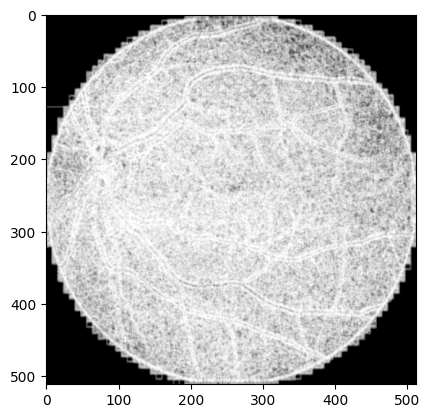

In [32]:
evaluate(binary_image.astype(np.uint8), img_GT)
plt.imshow(entropy_image, cmap = 'gray')